In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.append('../src/')
import os

In [2]:
from model.utils.metrics import l2_loss, explained_reconstruction, mean_correlation, importance_correlation, main_exprec
from least_volume_image import *
from dataset.images import MNISTImages, CIFAR10Images, ImageToyDataset, CelebAImages
from torch.nn.functional import mse_loss
from torch.utils.data import DataLoader
from math import sqrt

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, accuracy_score
from tqdm import tqdm
from sklearn.decomposition import PCA

In [4]:
def load_vol(src, dataset, cv, lam, epoch, device='cpu'):
    path = os.path.join(src, dataset, cv, 'vol', 'vol_{}_e1.0'.format(lam))
    configs = read_configs('{}_vol'.format(dataset), src=path)
    ae = VolumeAE_BCE(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to(device)
    ae.load(os.path.join(path, 'vol_{}{}.tar'.format(dataset, epoch)), map_location=device)
    ae.eval()
    return ae

def load_vol2(src, dataset, cv, lam, epoch, device='cpu'):
    path = os.path.join(src, dataset, cv, 'vol', 'vol_{}_e1.0'.format(lam))
    configs = read_configs('{}_vol'.format(dataset), src=path)
    ae = VolumeAE_BCE(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to(device)
    ae.load(os.path.join(path, '{}{}.tar'.format(dataset, epoch)), map_location=device)
    ae.eval()
    return ae

def load_l1(src, dataset, cv, lam, epoch, device='cpu'):
    path = os.path.join(src, dataset, cv, 'l1', 'l1_{}'.format(lam))
    configs = read_configs('{}_l1'.format(dataset), src=path)
    ae = L1AE_BCE(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to(device)
    ae.load(os.path.join(path, 'l1_{}{}.tar'.format(dataset, epoch)), map_location=device)
    ae.eval()
    return ae

def load_l12(src, dataset, cv, lam, epoch, device='cpu'):
    path = os.path.join(src, dataset, cv, 'l1', 'l1_{}'.format(lam))
    configs = read_configs('{}'.format(dataset), src=path)
    ae = L1AE_BCE(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to(device)
    ae.load(os.path.join(path, '{}{}.tar'.format(dataset, epoch)), map_location=device)
    ae.eval()
    return ae

def load_lasso(src, dataset, cv, lam, epoch, device='cpu'):
    path = os.path.join(src, dataset, cv, 'lasso', 'lasso_{}'.format(lam))
    configs = read_configs('{}'.format(dataset), src=path)
    ae = LassoAE_BCE(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to(device)
    ae.load(os.path.join(path, '{}{}.tar'.format(dataset, epoch)), map_location=device)
    ae.eval()
    return ae

def load_st(src, dataset, cv, lam, epoch, device='cpu'):
    path = os.path.join(src, dataset, cv, 'st', 'st_{}'.format(lam))
    configs = read_configs('{}'.format(dataset), src=path)
    ae = STAE_BCE(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to(device)
    ae.load(os.path.join(path, '{}{}.tar'.format(dataset, epoch)), map_location=device)
    ae.eval()
    return ae

def load_non(src, dataset, cv, epoch, device='cpu'):
    path = os.path.join(src, dataset, cv, 'non', 'bce_0.0')
    configs = read_configs('{}'.format(dataset), src=path)
    ae = BCEAutoencoder(configs, DCDiscriminator, TrueSNDCGeneratorSig, Adam).to(device)
    ae.load(os.path.join(path, 'non_{}{}.tar'.format(dataset, epoch)), map_location=device)
    ae.eval()
    return ae

# MNIST

In [12]:
device = 'cpu'
epoch = 399
src = '../saves/image/'
dataset_name = 'mnist'
cvs = ['cv0', 'cv1', 'cv2']

In [13]:
x_train = MNISTImages(train=True, device=device)[:]
x_test = MNISTImages(train=False, device=device)[:]
y_train = torch.load('../data/mnist/train_labels.pt')
y_test = torch.load('../data/mnist/test_labels.pt')

In [9]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_train.flatten(1), y_train)
y_hat = neigh.predict(x_test.flatten(1))
print('recall = {}, precision = {}, accuracy = {}'.format(
    recall_score(y_test, y_hat, average='macro'),
    precision_score(y_test, y_hat, average='macro'),
    accuracy_score(y_test, y_hat)
    )
)

# lr = LogisticRegression()
# lr.fit(x_train.flatten(1), y_train)
# y_hat = lr.predict(x_test.flatten(1))
# print('recall = {}, precision = {}'.format(
#     recall_score(y_test, y_hat, average='macro'),
#     precision_score(y_test, y_hat, average='macro')
#     )
# )

recall = 0.9726463717785301, precision = 0.9730862572588528, accuracy = 0.9729


In [17]:
rs, ps, acs = [], [], []
for cv in tqdm(cvs):
    volae = load_vol(src, dataset_name, cv, 1e-3, epoch, device)
    with torch.no_grad():
        z_train = volae.encode(x_train)
        z_test = volae.encode(x_test)

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(z_train, y_train)
    y_hat = neigh.predict(z_test)
    rs.append(recall_score(y_test, y_hat, average='macro'))
    ps.append(precision_score(y_test, y_hat, average='macro'))
    acs.append(accuracy_score(y_test, y_hat))

print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
    np.mean(rs), np.std(rs),
    np.mean(ps), np.std(ps),
    np.mean(acs), np.std(acs)
    )
)

# lr = LogisticRegression()
# lr.fit(z_train, y_train)
# y_hat = lr.predict(z_test)
# print('recall = {}, precision = {}'.format(
#     recall_score(y_test, y_hat, average='macro'),
#     precision_score(y_test, y_hat, average='macro')
#     )
# )

100%|██████████| 3/3 [00:07<00:00,  2.45s/it]

recall = 96.68% ± 0.03%
precision = 96.73% ± 0.03%
accuracy = 96.73% ± 0.03%


In [14]:
for lam in [3e-2, 1e-2, 3e-3, 1e-3, 3e-4]:
    rs, ps, acs = [], [], []
    for cv in tqdm(cvs):
        volae = load_vol(src, dataset_name, cv, lam, epoch, device) # 3e-3
        with torch.no_grad():
            z_train = volae.encode(x_train)
            z_test = volae.encode(x_test)

        neigh = KNeighborsClassifier(n_neighbors=5)
        neigh.fit(z_train, y_train)
        y_hat = neigh.predict(z_test)
        rs.append(recall_score(y_test, y_hat, average='macro'))
        ps.append(precision_score(y_test, y_hat, average='macro'))
        acs.append(accuracy_score(y_test, y_hat))

    print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
        np.mean(rs), np.std(rs),
        np.mean(ps), np.std(ps),
        np.mean(acs), np.std(acs)
        )
    )

100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


recall = 32.15% ± 2.39%
precision = 30.19% ± 2.63%
accuracy = 33.11% ± 2.38%


100%|██████████| 3/3 [00:07<00:00,  2.65s/it]


recall = 37.55% ± 2.13%
precision = 36.02% ± 2.19%
accuracy = 38.49% ± 2.19%


100%|██████████| 3/3 [00:07<00:00,  2.65s/it]


recall = 97.39% ± 0.47%
precision = 97.43% ± 0.46%
accuracy = 97.43% ± 0.46%


100%|██████████| 3/3 [00:08<00:00,  2.75s/it]


recall = 96.68% ± 0.03%
precision = 96.73% ± 0.03%
accuracy = 96.73% ± 0.03%


100%|██████████| 3/3 [00:08<00:00,  2.69s/it]

recall = 96.89% ± 0.10%
precision = 96.93% ± 0.09%
accuracy = 96.93% ± 0.10%


In [107]:
rs, ps, acs = [], [], []
for cv in tqdm(cvs):
    l1ae = load_l1(src, dataset_name, cv, 3e-3, epoch, device)
    with torch.no_grad():
        z_train = l1ae.encode(x_train)
        z_test = l1ae.encode(x_test)

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(z_train, y_train)
    y_hat = neigh.predict(z_test)
    rs.append(recall_score(y_test, y_hat, average='macro'))
    ps.append(precision_score(y_test, y_hat, average='macro'))
    acs.append(accuracy_score(y_test, y_hat))

print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
    np.mean(rs), np.std(rs),
    np.mean(ps), np.std(ps),
    np.mean(acs), np.std(acs)
    )
)

# lr = LogisticRegression()
# lr.fit(z_train, y_train)
# y_hat = lr.predict(z_test)
# print('recall = {}, precision = {}'.format(
#     recall_score(y_test, y_hat, average='macro'),
#     precision_score(y_test, y_hat, average='macro')
#     )
# )

100%|██████████| 3/3 [00:07<00:00,  2.53s/it]

recall = 97.29% ± 0.08%
precision = 97.33% ± 0.09%
accuracy = 97.32% ± 0.08%


In [15]:
for lam in [3e-2, 1e-2, 3e-3, 1e-3, 3e-4]:
    rs, ps, acs = [], [], []
    for cv in tqdm(cvs):
        l1ae = load_l1(src, dataset_name, cv, lam, epoch, device)
        with torch.no_grad():
            z_train = l1ae.encode(x_train)
            z_test = l1ae.encode(x_test)

        neigh = KNeighborsClassifier(n_neighbors=5)
        neigh.fit(z_train, y_train)
        y_hat = neigh.predict(z_test)
        rs.append(recall_score(y_test, y_hat, average='macro'))
        ps.append(precision_score(y_test, y_hat, average='macro'))
        acs.append(accuracy_score(y_test, y_hat))

    print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
        np.mean(rs), np.std(rs),
        np.mean(ps), np.std(ps),
        np.mean(acs), np.std(acs)
        )
    )

100%|██████████| 3/3 [00:07<00:00,  2.65s/it]


recall = 30.31% ± 3.43%
precision = 28.79% ± 4.01%
accuracy = 31.31% ± 3.41%


100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


recall = 39.69% ± 9.58%
precision = 37.75% ± 10.32%
accuracy = 40.56% ± 9.49%


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


recall = 97.29% ± 0.08%
precision = 97.33% ± 0.09%
accuracy = 97.32% ± 0.08%


100%|██████████| 3/3 [00:07<00:00,  2.60s/it]


recall = 97.23% ± 0.04%
precision = 97.27% ± 0.04%
accuracy = 97.27% ± 0.04%


100%|██████████| 3/3 [00:07<00:00,  2.54s/it]

recall = 97.27% ± 0.01%
precision = 97.30% ± 0.01%
accuracy = 97.31% ± 0.01%


In [108]:
rs, ps, acs = [], [], []
for cv in tqdm(cvs):
    lassoae = load_lasso(src, dataset_name, cv, 1e-2, epoch, device)
    with torch.no_grad():
        z_train = lassoae.encode(x_train)
        z_test = lassoae.encode(x_test)

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(z_train, y_train)
    y_hat = neigh.predict(z_test)
    rs.append(recall_score(y_test, y_hat, average='macro'))
    ps.append(precision_score(y_test, y_hat, average='macro'))
    acs.append(accuracy_score(y_test, y_hat))

print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
    np.mean(rs), np.std(rs),
    np.mean(ps), np.std(ps),
    np.mean(acs), np.std(acs)
    )
)

# lr = LogisticRegression()
# lr.fit(z_train, y_train)
# y_hat = lr.predict(z_test)
# print('recall = {}, precision = {}'.format(
#     recall_score(y_test, y_hat, average='macro'),
#     precision_score(y_test, y_hat, average='macro')
#     )
# )

100%|██████████| 3/3 [00:07<00:00,  2.55s/it]

recall = 97.19% ± 0.02%
precision = 97.22% ± 0.02%
accuracy = 97.22% ± 0.02%


In [16]:
for lam in [3e-2, 1e-2, 3e-3, 1e-3, 3e-4]:
    for cv in tqdm(cvs):
        lassoae = load_lasso(src, dataset_name, cv, lam, epoch, device)
        with torch.no_grad():
            z_train = lassoae.encode(x_train)
            z_test = lassoae.encode(x_test)

        neigh = KNeighborsClassifier(n_neighbors=5)
        neigh.fit(z_train, y_train)
        y_hat = neigh.predict(z_test)
        rs.append(recall_score(y_test, y_hat, average='macro'))
        ps.append(precision_score(y_test, y_hat, average='macro'))
        acs.append(accuracy_score(y_test, y_hat))

    print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
        np.mean(rs), np.std(rs),
        np.mean(ps), np.std(ps),
        np.mean(acs), np.std(acs)
        )
    )

100%|██████████| 3/3 [00:07<00:00,  2.61s/it]


recall = 97.15% ± 0.14%
precision = 97.18% ± 0.14%
accuracy = 97.19% ± 0.14%


100%|██████████| 3/3 [00:08<00:00,  2.71s/it]


recall = 97.17% ± 0.12%
precision = 97.19% ± 0.11%
accuracy = 97.20% ± 0.11%


100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


recall = 97.22% ± 0.14%
precision = 97.24% ± 0.14%
accuracy = 97.25% ± 0.14%


100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


recall = 97.23% ± 0.13%
precision = 97.26% ± 0.13%
accuracy = 97.27% ± 0.13%


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]

recall = 97.25% ± 0.13%
precision = 97.28% ± 0.13%
accuracy = 97.29% ± 0.13%


In [109]:
rs, ps, acs = [], [], []
for cv in tqdm(cvs):
    stae = load_st(src, dataset_name, cv, 3e-2, epoch, device)
    with torch.no_grad():
        z_train = stae.encode(x_train)
        z_test = stae.encode(x_test)

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(z_train, y_train)
    y_hat = neigh.predict(z_test)
    rs.append(recall_score(y_test, y_hat, average='macro'))
    ps.append(precision_score(y_test, y_hat, average='macro'))
    acs.append(accuracy_score(y_test, y_hat))

print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
    np.mean(rs), np.std(rs),
    np.mean(ps), np.std(ps),
    np.mean(acs), np.std(acs)
    )
)

# lr = LogisticRegression()
# lr.fit(z_train, y_train)
# y_hat = lr.predict(z_test)
# print('recall = {}, precision = {}'.format(
#     recall_score(y_test, y_hat, average='macro'),
#     precision_score(y_test, y_hat, average='macro')
#     )
# )

100%|██████████| 3/3 [00:07<00:00,  2.52s/it]

recall = 95.63% ± 0.20%
precision = 95.70% ± 0.17%
accuracy = 95.70% ± 0.19%


In [17]:
for lam in [3e-2, 1e-2, 3e-3, 1e-3, 3e-4]:
    rs, ps, acs = [], [], []
    for cv in tqdm(cvs):
        stae = load_st(src, dataset_name, cv, lam, epoch, device)
        with torch.no_grad():
            z_train = stae.encode(x_train)
            z_test = stae.encode(x_test)

        neigh = KNeighborsClassifier(n_neighbors=5)
        neigh.fit(z_train, y_train)
        y_hat = neigh.predict(z_test)
        rs.append(recall_score(y_test, y_hat, average='macro'))
        ps.append(precision_score(y_test, y_hat, average='macro'))
        acs.append(accuracy_score(y_test, y_hat))

    print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
        np.mean(rs), np.std(rs),
        np.mean(ps), np.std(ps),
        np.mean(acs), np.std(acs)
        )
    )

100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


recall = 95.63% ± 0.20%
precision = 95.70% ± 0.17%
accuracy = 95.70% ± 0.19%


100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


recall = 96.29% ± 0.13%
precision = 96.34% ± 0.12%
accuracy = 96.36% ± 0.12%


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


recall = 96.34% ± 0.04%
precision = 96.39% ± 0.05%
accuracy = 96.39% ± 0.04%


100%|██████████| 3/3 [00:07<00:00,  2.61s/it]


recall = 96.44% ± 0.14%
precision = 96.49% ± 0.14%
accuracy = 96.49% ± 0.13%


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]

recall = 97.26% ± 0.09%
precision = 97.29% ± 0.09%
accuracy = 97.29% ± 0.09%


# CIFAR-10

In [18]:
device = 'cpu'
epoch = 999
src = '../saves/image/'
dataset_name = 'cifar10'
cvs = ['cv0', 'cv1', 'cv2']

In [19]:
x_train = CIFAR10Images(train=True, device=device)[:]
x_test = CIFAR10Images(train=False, device=device)[:]
y_train = torch.load('../data/cifar10/train_labels.pt')
y_test = torch.load('../data/cifar10/test_labels.pt')

In [86]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_train.flatten(1), y_train)
y_hat = neigh.predict(x_test.flatten(1))
print('recall = {}, precision = {}, accuracy = {}'.format(
    recall_score(y_test, y_hat, average='macro'),
    precision_score(y_test, y_hat, average='macro'),
    accuracy_score(y_test, y_hat)
    )
)

recall = 0.3398, precision = 0.43042618255284965, accuracy = 0.3398


### Vol

In [128]:
rs, ps, acs = [], [], []
for cv in tqdm(cvs):
    volae = load_vol(src, dataset_name, cv, 3e-3, epoch, device) # 3e-3
    with torch.no_grad():
        z_train = volae.encode(x_train)
        z_test = volae.encode(x_test)

        # idx = torch.argsort(z_train.std(0), descending=True)[1300:]
        # mean = z_train.mean(0)
        # z_train[:, idx] = mean[idx]
        # z_test[:, idx] = mean[idx]

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(z_train, y_train)
    y_hat = neigh.predict(z_test)
    rs.append(recall_score(y_test, y_hat, average='macro'))
    ps.append(precision_score(y_test, y_hat, average='macro'))
    acs.append(accuracy_score(y_test, y_hat))

print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
    np.mean(rs), np.std(rs),
    np.mean(ps), np.std(ps),
    np.mean(acs), np.std(acs)
    )
)

100%|██████████| 3/3 [01:40<00:00, 33.66s/it]

recall = 41.08% ± 0.41%
precision = 42.15% ± 0.34%
accuracy = 41.08% ± 0.41%


In [8]:
for lam in [3e-2, 1e-2, 3e-3, 1e-3, 3e-4]:
    rs, ps, acs = [], [], []
    for cv in tqdm(cvs):
        volae = load_vol(src, dataset_name, cv, lam, epoch, device) # 3e-3
        with torch.no_grad():
            z_train = volae.encode(x_train)
            z_test = volae.encode(x_test)

        neigh = KNeighborsClassifier(n_neighbors=5)
        neigh.fit(z_train, y_train)
        y_hat = neigh.predict(z_test)
        rs.append(recall_score(y_test, y_hat, average='macro'))
        ps.append(precision_score(y_test, y_hat, average='macro'))
        acs.append(accuracy_score(y_test, y_hat))

    print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
        np.mean(rs), np.std(rs),
        np.mean(ps), np.std(ps),
        np.mean(acs), np.std(acs)
        )
    )

100%|██████████| 3/3 [00:44<00:00, 14.92s/it]


recall = 36.19% ± 0.20%
precision = 43.08% ± 0.17%
accuracy = 36.19% ± 0.20%


100%|██████████| 3/3 [00:46<00:00, 15.60s/it]


recall = 34.73% ± 0.59%
precision = 41.29% ± 0.59%
accuracy = 34.73% ± 0.59%


100%|██████████| 3/3 [00:46<00:00, 15.60s/it]


recall = 41.08% ± 0.41%
precision = 42.15% ± 0.34%
accuracy = 41.08% ± 0.41%


100%|██████████| 3/3 [00:44<00:00, 14.75s/it]


recall = 42.35% ± 0.20%
precision = 43.72% ± 0.44%
accuracy = 42.35% ± 0.20%


100%|██████████| 3/3 [00:44<00:00, 14.79s/it]

recall = 44.07% ± 0.11%
precision = 45.19% ± 0.10%
accuracy = 44.07% ± 0.11%


100%|██████████| 1/1 [00:09<00:00,  9.89s/it]


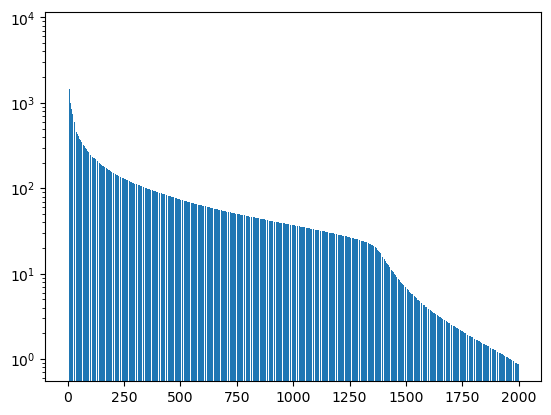

In [29]:
for cv in tqdm(cvs[:1]):
    stae = load_vol(src, dataset_name, cv, 3e-4, epoch, device)
    with torch.no_grad():
        z_train = stae.encode(x_train)
        z_test = stae.encode(x_test)

pca = PCA().fit(z_test)

plt.bar(range(2000), pca.singular_values_[:2000])
plt.yscale('log')
plt.show()

### L1

In [116]:
rs, ps, acs = [], [], []
for cv in tqdm(cvs):
    l1ae = load_l1(src, dataset_name, cv, 3e-3, epoch, device)
    with torch.no_grad():
        z_train = l1ae.encode(x_train)
        z_test = l1ae.encode(x_test)

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(z_train, y_train)
    y_hat = neigh.predict(z_test)
    rs.append(recall_score(y_test, y_hat, average='macro'))
    ps.append(precision_score(y_test, y_hat, average='macro'))
    acs.append(accuracy_score(y_test, y_hat))

print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
    np.mean(rs), np.std(rs),
    np.mean(ps), np.std(ps),
    np.mean(acs), np.std(acs)
    )
)

100%|██████████| 3/3 [00:42<00:00, 14.08s/it]

recall = 34.40% ± 0.09%
precision = 41.93% ± 0.11%
accuracy = 34.40% ± 0.09%


In [9]:
for lam in [3e-2, 1e-2, 3e-3, 1e-3, 3e-4]:
    rs, ps, acs = [], [], []
    for cv in tqdm(cvs):
        l1ae = load_l1(src, dataset_name, cv, lam, epoch, device)
        with torch.no_grad():
            z_train = l1ae.encode(x_train)
            z_test = l1ae.encode(x_test)

        neigh = KNeighborsClassifier(n_neighbors=5)
        neigh.fit(z_train, y_train)
        y_hat = neigh.predict(z_test)
        rs.append(recall_score(y_test, y_hat, average='macro'))
        ps.append(precision_score(y_test, y_hat, average='macro'))
        acs.append(accuracy_score(y_test, y_hat))

    print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
        np.mean(rs), np.std(rs),
        np.mean(ps), np.std(ps),
        np.mean(acs), np.std(acs)
        )
    )

100%|██████████| 3/3 [00:42<00:00, 14.10s/it]


recall = 36.71% ± 0.10%
precision = 43.40% ± 0.17%
accuracy = 36.71% ± 0.10%


100%|██████████| 3/3 [00:42<00:00, 14.15s/it]


recall = 34.90% ± 0.14%
precision = 42.42% ± 0.07%
accuracy = 34.90% ± 0.14%


100%|██████████| 3/3 [00:43<00:00, 14.59s/it]


recall = 34.40% ± 0.09%
precision = 41.93% ± 0.11%
accuracy = 34.40% ± 0.09%


100%|██████████| 3/3 [00:42<00:00, 14.18s/it]


recall = 34.27% ± 0.11%
precision = 41.94% ± 0.19%
accuracy = 34.27% ± 0.11%


100%|██████████| 3/3 [00:41<00:00, 13.90s/it]

recall = 35.47% ± 1.78%
precision = 42.92% ± 0.94%
accuracy = 35.47% ± 1.78%


100%|██████████| 1/1 [00:10<00:00, 10.10s/it]


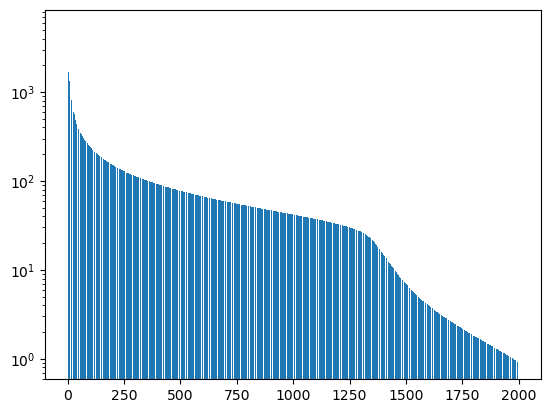

In [30]:
for cv in tqdm(cvs[:1]):
    stae = load_l1(src, dataset_name, cv, 3e-4, epoch, device)
    with torch.no_grad():
        z_train = stae.encode(x_train)
        z_test = stae.encode(x_test)

pca = PCA().fit(z_test)

plt.bar(range(2000), pca.singular_values_[:2000])
plt.yscale('log')
plt.show()

### Lasso

In [94]:
rs, ps, acs = [], [], []
for cv in tqdm(cvs):
    lassoae = load_lasso(src, dataset_name, cv, 3e-3, epoch, device)
    with torch.no_grad():
        z_train = lassoae.encode(x_train)
        z_test = lassoae.encode(x_test)

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(z_train, y_train)
    y_hat = neigh.predict(z_test)
    rs.append(recall_score(y_test, y_hat, average='macro'))
    ps.append(precision_score(y_test, y_hat, average='macro'))
    acs.append(accuracy_score(y_test, y_hat))

print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
    np.mean(rs), np.std(rs),
    np.mean(ps), np.std(ps),
    np.mean(acs), np.std(acs)
    )
)

100%|██████████| 3/3 [00:42<00:00, 14.15s/it]

recall = 34.34% ± 0.23%
precision = 41.97% ± 0.43%
accuracy = 34.34% ± 0.23%


In [10]:
for lam in [3e-2, 1e-2, 3e-3, 1e-3, 3e-4]:
    for cv in tqdm(cvs):
        lassoae = load_lasso(src, dataset_name, cv, lam, epoch, device)
        with torch.no_grad():
            z_train = lassoae.encode(x_train)
            z_test = lassoae.encode(x_test)

        neigh = KNeighborsClassifier(n_neighbors=5)
        neigh.fit(z_train, y_train)
        y_hat = neigh.predict(z_test)
        rs.append(recall_score(y_test, y_hat, average='macro'))
        ps.append(precision_score(y_test, y_hat, average='macro'))
        acs.append(accuracy_score(y_test, y_hat))

    print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
        np.mean(rs), np.std(rs),
        np.mean(ps), np.std(ps),
        np.mean(acs), np.std(acs)
        )
    )

100%|██████████| 3/3 [00:43<00:00, 14.61s/it]


recall = 35.67% ± 1.28%
precision = 42.92% ± 0.68%
accuracy = 35.68% ± 1.28%


100%|██████████| 3/3 [00:41<00:00, 13.77s/it]


recall = 35.25% ± 1.20%
precision = 42.52% ± 0.80%
accuracy = 35.25% ± 1.20%


100%|██████████| 3/3 [00:41<00:00, 13.70s/it]


recall = 35.02% ± 1.12%
precision = 42.38% ± 0.76%
accuracy = 35.02% ± 1.12%


100%|██████████| 3/3 [00:43<00:00, 14.38s/it]


recall = 35.41% ± 1.29%
precision = 42.51% ± 0.74%
accuracy = 35.41% ± 1.29%


100%|██████████| 3/3 [00:43<00:00, 14.40s/it]

recall = 36.74% ± 3.19%
precision = 43.04% ± 1.37%
accuracy = 36.74% ± 3.19%


100%|██████████| 1/1 [00:10<00:00, 10.67s/it]


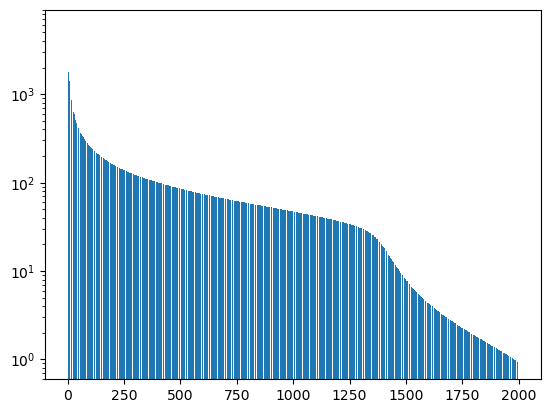

In [31]:
for cv in tqdm(cvs[:1]):
    stae = load_lasso(src, dataset_name, cv, 3e-4, epoch, device)
    with torch.no_grad():
        z_train = stae.encode(x_train)
        z_test = stae.encode(x_test)

pca = PCA().fit(z_test)

plt.bar(range(2000), pca.singular_values_[:2000])
plt.yscale('log')
plt.show()

#### ST

In [95]:
rs, ps, acs = [], [], []
for cv in tqdm(cvs):
    stae = load_st(src, dataset_name, cv, 3e-2, epoch, device)
    with torch.no_grad():
        z_train = stae.encode(x_train)
        z_test = stae.encode(x_test)

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(z_train, y_train)
    y_hat = neigh.predict(z_test)
    rs.append(recall_score(y_test, y_hat, average='macro'))
    ps.append(precision_score(y_test, y_hat, average='macro'))
    acs.append(accuracy_score(y_test, y_hat))

print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
    np.mean(rs), np.std(rs),
    np.mean(ps), np.std(ps),
    np.mean(acs), np.std(acs)
    )
)

100%|██████████| 3/3 [00:43<00:00, 14.44s/it]

recall = 34.96% ± 1.57%
precision = 37.64% ± 0.09%
accuracy = 34.96% ± 1.57%


In [11]:
for lam in [3e-2, 1e-2, 3e-3, 1e-3, 3e-4]:
    rs, ps, acs = [], [], []
    for cv in tqdm(cvs):
        stae = load_st(src, dataset_name, cv, lam, epoch, device)
        with torch.no_grad():
            z_train = stae.encode(x_train)
            z_test = stae.encode(x_test)

        neigh = KNeighborsClassifier(n_neighbors=5)
        neigh.fit(z_train, y_train)
        y_hat = neigh.predict(z_test)
        rs.append(recall_score(y_test, y_hat, average='macro'))
        ps.append(precision_score(y_test, y_hat, average='macro'))
        acs.append(accuracy_score(y_test, y_hat))

    print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
        np.mean(rs), np.std(rs),
        np.mean(ps), np.std(ps),
        np.mean(acs), np.std(acs)
        )
    )

100%|██████████| 3/3 [00:41<00:00, 13.84s/it]


recall = 34.96% ± 1.57%
precision = 37.64% ± 0.09%
accuracy = 34.96% ± 1.57%


100%|██████████| 3/3 [00:43<00:00, 14.36s/it]


recall = 40.47% ± 0.43%
precision = 41.34% ± 0.36%
accuracy = 40.47% ± 0.43%


100%|██████████| 3/3 [00:43<00:00, 14.41s/it]


recall = 40.78% ± 0.14%
precision = 41.99% ± 0.15%
accuracy = 40.78% ± 0.14%


100%|██████████| 3/3 [00:42<00:00, 14.33s/it]


recall = 42.02% ± 0.38%
precision = 42.81% ± 0.63%
accuracy = 42.02% ± 0.38%


100%|██████████| 3/3 [00:41<00:00, 13.72s/it]

recall = 44.07% ± 0.41%
precision = 44.99% ± 0.36%
accuracy = 44.07% ± 0.41%


100%|██████████| 1/1 [00:09<00:00,  9.80s/it]


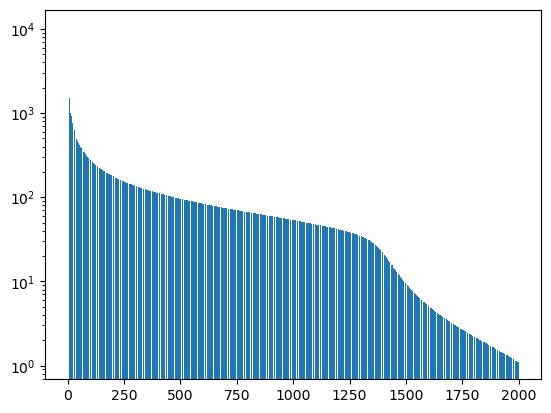

In [32]:
for cv in tqdm(cvs[:1]):
    stae = load_st(src, dataset_name, cv, 3e-4, epoch, device)
    with torch.no_grad():
        z_train = stae.encode(x_train)
        z_test = stae.encode(x_test)

pca = PCA().fit(z_test)

plt.bar(range(2000), pca.singular_values_[:2000])
plt.yscale('log')
plt.show()

# CelebA

In [22]:
device = 'cpu'
epoch = 199
src = '../saves/image/'
dataset_name = 'celeba'
cvs = ['cv0', 'cv1', 'cv2']

In [23]:
x_train = CelebAImages(train=True, device=device)[:]
x_test = CelebAImages(train=False, device=device)[:]
y_train = torch.load('../data/celeba/train_labels.pt')
y_test = torch.load('../data/celeba/test_labels.pt')

In [24]:
neigh = KNeighborsClassifier(n_neighbors=50)
neigh.fit(x_train.flatten(1), y_train)
y_hat = neigh.predict(x_test.flatten(1))
print('recall = {}, precision = {}, accuracy = {}'.format(
    recall_score(y_test, y_hat, average='macro'),
    precision_score(y_test, y_hat, average='macro'),
    accuracy_score(y_test, y_hat)
    )
)

recall = 0.32140004186349114, precision = 0.49068835585929005, accuracy = 0.0017032361486824968


In [39]:
rs, ps, acs = [], [], []
for cv in tqdm(cvs):
    volae = load_vol2(src, dataset_name, cv, 1e-3, epoch, device)
    with torch.no_grad():
        z_train = volae.encode(x_train)
        z_test = volae.encode(x_test)

        # idx = torch.argsort(z_train.std(0), descending=True)[1300:]
        # mean = z_train.mean(0)
        # z_train[:, idx] = mean[idx]
        # z_test[:, idx] = mean[idx]

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(z_train, y_train)
    y_hat = neigh.predict(z_test)
    rs.append(recall_score(y_test, y_hat, average='macro'))
    ps.append(precision_score(y_test, y_hat, average='macro'))
    acs.append(accuracy_score(y_test, y_hat))

print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
    np.mean(rs), np.std(rs),
    np.mean(ps), np.std(ps),
    np.mean(acs), np.std(acs)
    )
)

100%|██████████| 3/3 [02:13<00:00, 44.50s/it]

recall = 30.44% ± 0.34%
precision = 47.58% ± 0.32%
accuracy = 0.17% ± 0.01%


In [36]:
rs, ps, acs = [], [], []
for cv in tqdm(cvs):
    l1ae = load_l12(src, dataset_name, cv, 3e-3, epoch, device)
    with torch.no_grad():
        z_train = l1ae.encode(x_train)
        z_test = l1ae.encode(x_test)

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(z_train, y_train)
    y_hat = neigh.predict(z_test)
    rs.append(recall_score(y_test, y_hat, average='macro'))
    ps.append(precision_score(y_test, y_hat, average='macro'))
    acs.append(accuracy_score(y_test, y_hat))

print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
    np.mean(rs), np.std(rs),
    np.mean(ps), np.std(ps),
    np.mean(acs), np.std(acs)
    )
)

100%|██████████| 3/3 [02:28<00:00, 49.36s/it]

recall = 31.28% ± 0.01%
precision = 48.25% ± 0.10%
accuracy = 0.12% ± 0.01%


In [ ]:
rs, ps, acs = [], [], []
for cv in tqdm(cvs):
    lassoae = load_lasso(src, dataset_name, cv, 3e-3, epoch, device)
    with torch.no_grad():
        z_train = lassoae.encode(x_train)
        z_test = lassoae.encode(x_test)

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(z_train, y_train)
    y_hat = neigh.predict(z_test)
    rs.append(recall_score(y_test, y_hat, average='macro'))
    ps.append(precision_score(y_test, y_hat, average='macro'))
    acs.append(accuracy_score(y_test, y_hat))

print('recall = {:.2%} ± {:.2%}\nprecision = {:.2%} ± {:.2%}\naccuracy = {:.2%} ± {:.2%}'.format(
    np.mean(rs), np.std(rs),
    np.mean(ps), np.std(ps),
    np.mean(acs), np.std(acs)
    )
)